
# Fish Weight Prediction: Regression Model Comparison


In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

DATA_PATH = "Fish.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

## Task 1: Data Acquisition & Preparation

In [2]:
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
expected_cols = {"Species", "Weight", "Length1", "Length2", "Length3", "Height", "Width"}
missing_expected = expected_cols - set(df.columns)
if missing_expected:
    raise ValueError(f"Missing expected columns: {missing_expected}. Found: {list(df.columns)}")
display(df.isna().sum())
species_codes = {s:i for i,s in enumerate(sorted(df["Species"].unique()))}
df["Species_Code"] = df["Species"].map(species_codes)
display(df.head())

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

,Species,Weight,Length1,Length2,Length3,Height,Width,Species_Code
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,0
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,0
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,0
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,0
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,0


## Task 2: EDA & Feature Engineering

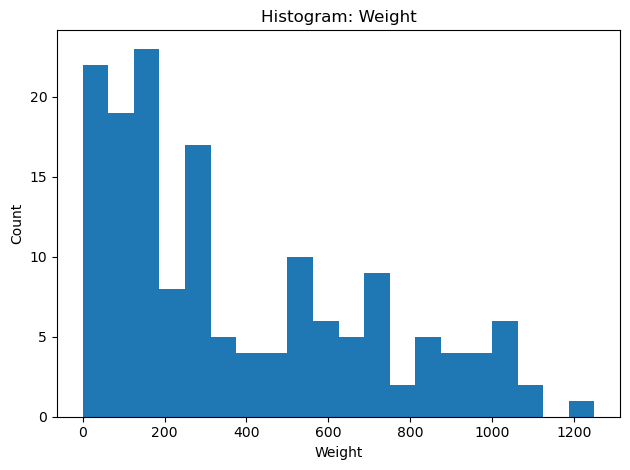

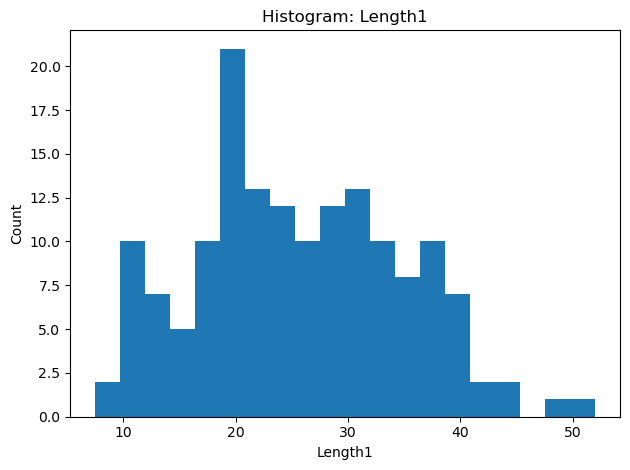

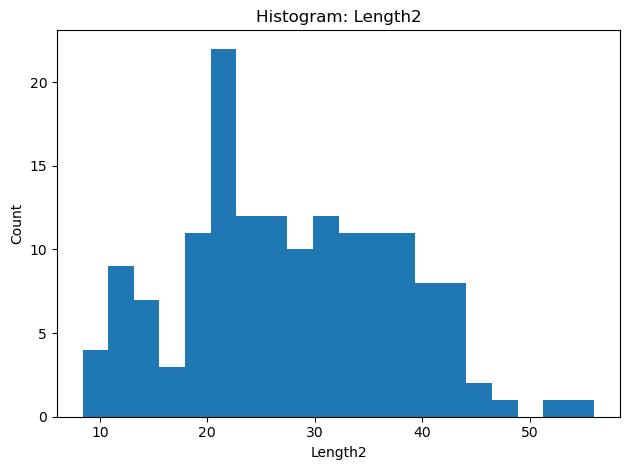

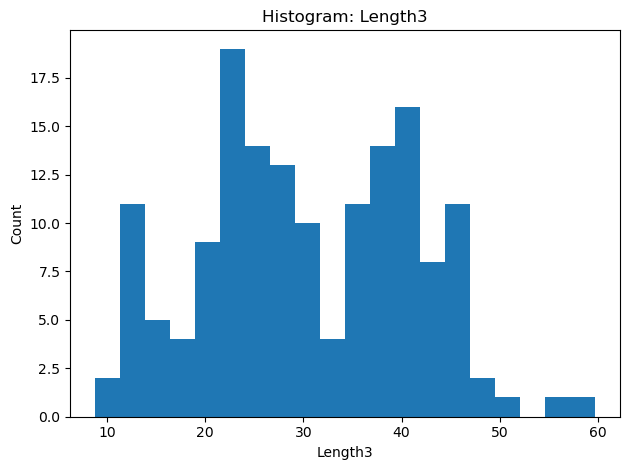

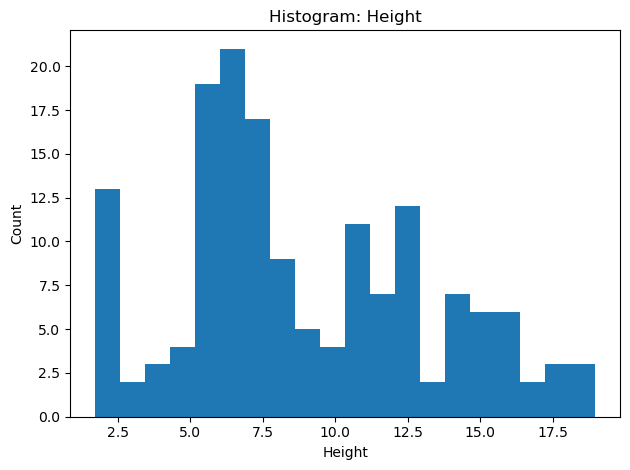

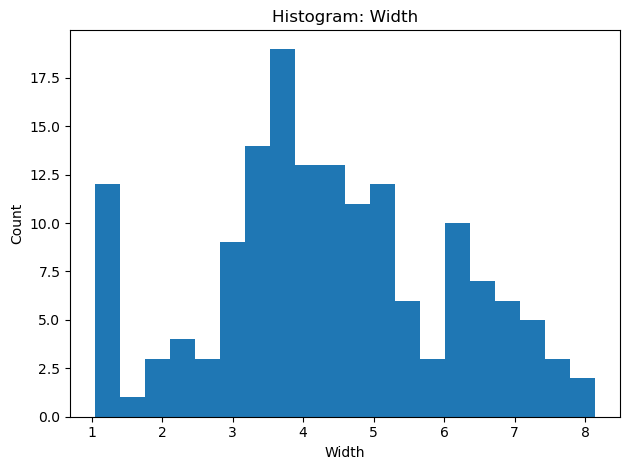

In [4]:
num_cols = ["Weight", "Length1", "Length2", "Length3", "Height", "Width"]

# Histograms
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_30632\3315596161.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[c].dropna().values for c in num_cols], labels=num_cols, vert=True)


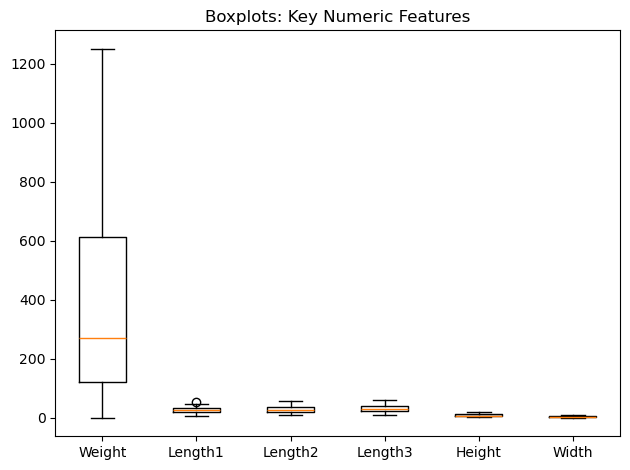

In [5]:
# Boxplots for outliers
plt.figure()
plt.boxplot([df[c].dropna().values for c in num_cols], labels=num_cols, vert=True)
plt.title("Boxplots: Key Numeric Features")
plt.tight_layout()
plt.show()

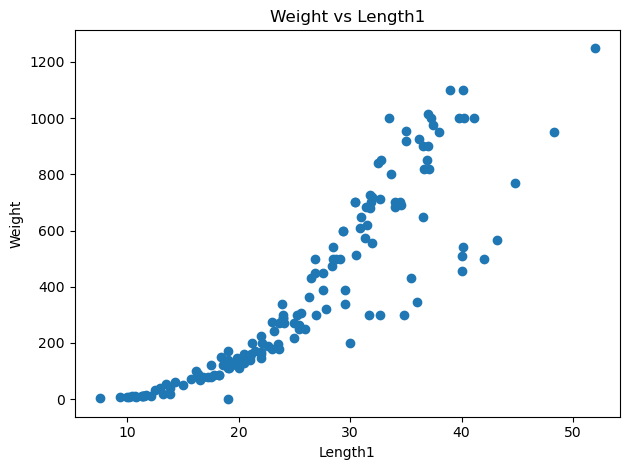

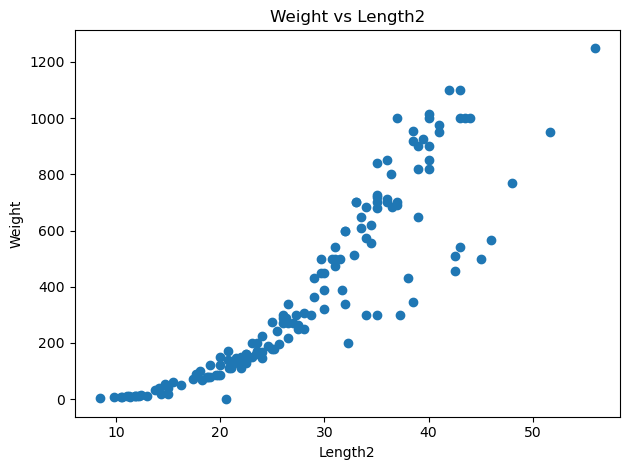

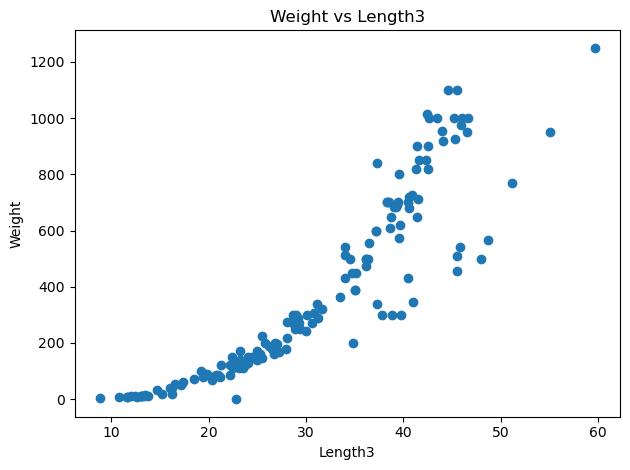

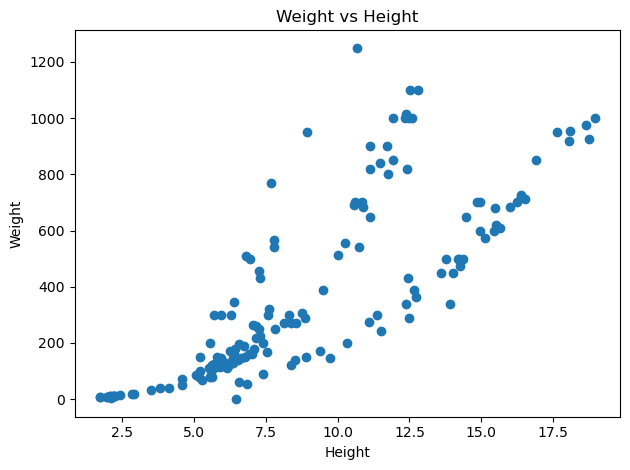

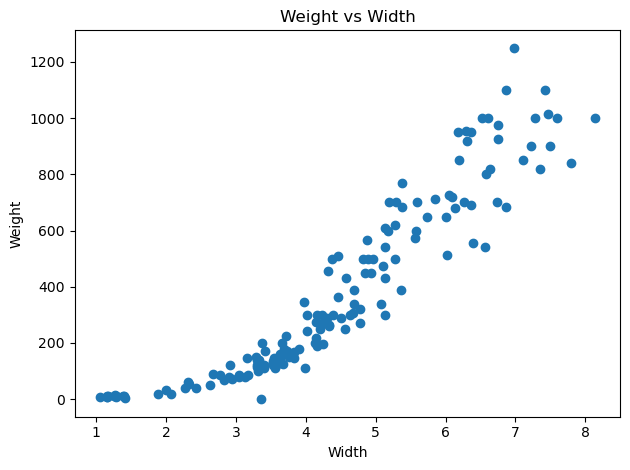

In [6]:
# Scatter: Weight vs features
for col in ["Length1", "Length2", "Length3", "Height", "Width"]:
    plt.figure()
    plt.scatter(df[col], df["Weight"])
    plt.xlabel(col)
    plt.ylabel("Weight")
    plt.title(f"Weight vs {col}")
    plt.tight_layout()
    plt.show()

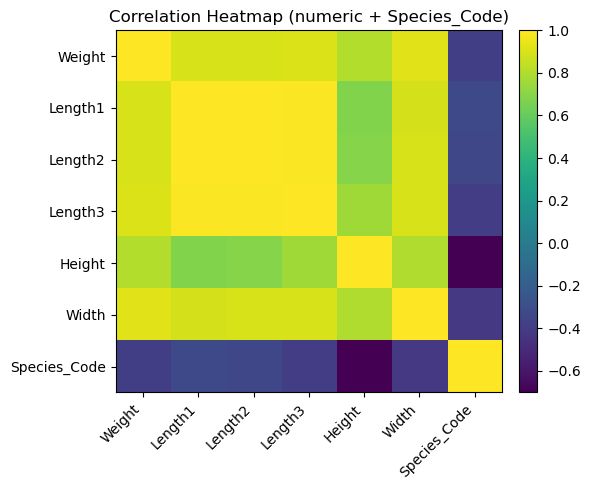

In [7]:
# Correlation heatmap
corr = df[num_cols + ["Species_Code"]].corr()
plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, aspect='auto')
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap (numeric + Species_Code)")
plt.tight_layout()
plt.show()

In [8]:
# Outlier handling on Weight using IQR
Q1 = df["Weight"].quantile(0.25)
Q3 = df["Weight"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

before_n = len(df)
df = df[(df["Weight"] >= lower) & (df["Weight"] <= upper)]
after_n = len(df)
print("Outliers removed (by Weight IQR):", before_n - after_n)

Outliers removed (by Weight IQR): 0


In [9]:
# Feature engineering
df["Length_mean"] = df[["Length1","Length2","Length3"]].mean(axis=1)
df["Area_approx"] = df["Height"] * df["Width"]
df["Volume_approx"] = df["Length3"] * df["Height"] * df["Width"]
df["L3xH"] = df["Length3"] * df["Height"]
df["L3xW"] = df["Length3"] * df["Width"]
df["HxW"] = df["Height"] * df["Width"]

display(df.head())

,Species,Weight,Length1,Length2,Length3,Height,Width,Species_Code,Length_mean,Area_approx,Volume_approx,L3xH,L3xW,HxW
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,0,26.200000,46.310400,1389.312000,345.60000,120.60000,46.310400
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,0,27.166667,53.733888,1676.497306,389.37600,134.33472,53.733888
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,0,27.166667,58.127387,1807.761723,384.94958,146.04871,58.127387
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,0,29.600000,56.718515,1900.070253,426.45500,149.25925,56.718515
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,0,29.833333,63.887496,2172.174864,423.09600,174.55600,63.887496


In [10]:
TARGET = "Weight"
FEATURES = [c for c in df.columns if c not in [TARGET, "Species_Code"]]

X = df[FEATURES].copy()
y = df[TARGET].copy()

categorical_cols = ["Species"] if "Species" in X.columns else []
numeric_cols = [c for c in X.columns if c not in categorical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Task 3: Model Development & Comparison

In [13]:

# Common preprocessors
num_preprocess = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_preprocess = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([("num", num_preprocess, numeric_cols), ("cat", cat_preprocess, categorical_cols)], remainder="drop", sparse_threshold=0.0)

# Models
linreg = Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
ridge = Pipeline([("preprocess", preprocess), ("model", RidgeCV(alphas=np.logspace(-4, 4, 20), cv=5, scoring="neg_mean_squared_error"))])
lasso = Pipeline([("preprocess", preprocess), ("model", LassoCV(alphas=np.logspace(-4, 1, 20), cv=5, max_iter=10000, random_state=42))])

poly_num = Pipeline([("imputer", SimpleImputer(strategy="median")), ("poly", PolynomialFeatures(degree=2, include_bias=False)), ("scaler", StandardScaler())])
poly_preprocess = ColumnTransformer([("num_poly", poly_num, numeric_cols), ("cat", cat_preprocess, categorical_cols)], remainder="drop", sparse_threshold=0.0)
polyreg = Pipeline([("preprocess", poly_preprocess), ("model", LinearRegression())])

models = {"LinearRegression": linreg, "RidgeCV": ridge, "LassoCV": lasso, "Polynomial(deg=2)": polyreg}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    alpha_info = None
    if name == "RidgeCV":
        alpha_info = model.named_steps["model"].alpha_
    if name == "LassoCV":
        alpha_info = float(model.named_steps["model"].alpha_)
    results.append({"Model": name, "RMSE": rmse, "R2": r2, "Alpha_or_NA": alpha_info})

results_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
display(results_df)


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1342.8084275017027, tolerance: 984.1572321818182
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\DuaaHilal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1339.163130543544, tolerance: 984.1572321818182
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\DuaaHilal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1322.1252069049515, tolerance: 984.1572321818182
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\DuaaHilal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_

,Model,RMSE,R2,Alpha_or_NA
0,RidgeCV,34.922129,0.988334,0.033598
1,LassoCV,35.118448,0.988202,0.078476
2,LinearRegression,35.269817,0.988100,NaN
3,Polynomial(deg=2),44.021158,0.981463,NaN


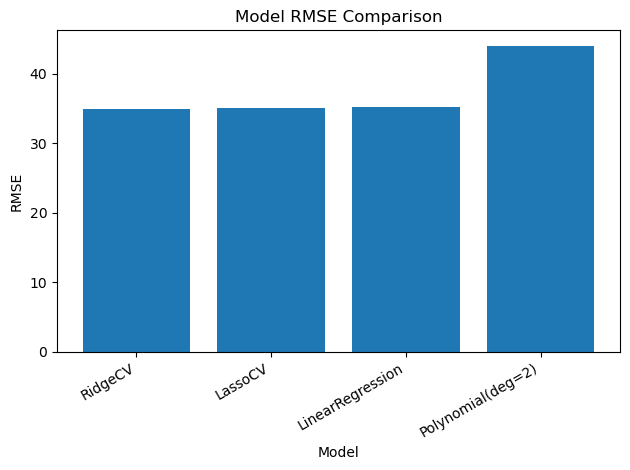

In [14]:
# Simple RMSE bar chart
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [15]:
# Save artifacts
clean_path = "fish_cleaned.csv"
df.to_csv(clean_path, index=False)
metrics_path = "fish_model_metrics.csv"
results_df.to_csv(metrics_path, index=False)
print("Saved:", clean_path)
print("Saved:", metrics_path)

Saved: fish_cleaned.csv
Saved: fish_model_metrics.csv
